# Creating the dataset from Reyes et al. (2011)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.8, Om0=0.308)

In [2]:
def calculate_Bell_stellar_masses(z, gr, Mr):
    ar_bell = -0.306
    br_bell = 1.097
    Mr_sun = 4.76
    Log10_Lr = -0.4 * (Mr - Mr_sun + 1.1*z)
    Log10_Ms_Lr = ar_bell + br_bell * gr - 0.093
    Log10_Ms = Log10_Lr + Log10_Ms_Lr
    return Log10_Ms


### Loading the samples

In [3]:
file = './raw_data/Reyes_2011.txt'
data = np.genfromtxt(file, usecols=(6), dtype="str")
galaxy_names = data[:] # SDSS Galaxy identifier
num_Reyes = len(galaxy_names)

data = np.genfromtxt(file, usecols=(10, 11, 13, 15, 16, 19))
z = data[:, 0] # Redshift
Mr = data[:, 1] # r-band Petrosian absolute magnitude
gr = data[:, 2] # g-r model colour
Reff = data[:, 3] # i-band Petrosian half-light radius

data = np.genfromtxt(file, usecols=(20, 23, 24, 26, 29))
sini = data[:, 1] # Inclination correction sin({theta})
Rto = data[:, 2] # Turn-over radius
Vc = data[:, 3] # Inclination-corrected asymptotic circular velocity
V2p2 = data[:, 4] # Inclination-corrected velocity amplitude at 2.2Rd

Mstellar = calculate_Bell_stellar_masses(z, gr, Mr)
Mstellar += np.log10(0.7**2)
Mstellar = 10**Mstellar

# angular diameter distance in kpc
d_A = cosmo.angular_diameter_distance(z=z).value * 1e3

# pi radian = 180 degree ==> 1deg = pi/180 ==> 1arcsec = pi/180/3600
# Reff_radian = Reff_arcsec * ( np.pi / 180 / 3600 )
# arc length = radius * angle
# Reff = d_A * Reff_radian

Reff_radian = Reff / d_A
Reff_arcsec = Reff_radian / ( np.pi / 180 / 3600 )

Vc_obs = sini * Vc
Vr_obs = (2. / np.pi) * Vc_obs * np.arctan(Reff_arcsec / Rto) # V(Reff) [km/s]
Vr = Vr_obs / sini

Msun_in_cgs = 1.98848e33
kpc_in_cgs = 3.08567758e21
G = 6.67408e-11 #(m/s)^2 m kg^-1 
G *= 1e2 * 1e-3 #(m/s)^2 cm g^-1 
G *= Msun_in_cgs #(m/s)^2 cm Msun^-1 
G /= (1e3)**2 #(km/s)^2 cm Msun^-1 
G /= kpc_in_cgs #(km/s)^2 kpc Msun^-1

Mtotal = Vr**2 * Reff # [(km/s)^2 x kpc]
Mtotal /= G # [Msun]
fDM = (Mtotal - 0.5 * Mstellar) / Mtotal

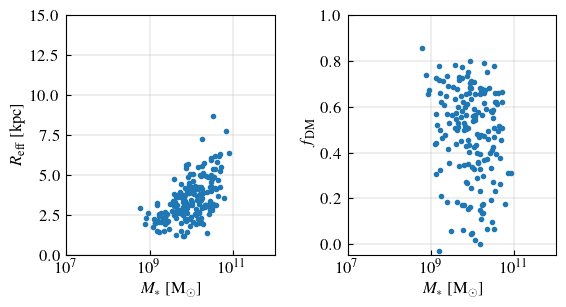

In [4]:
#################
# Plot parameters
params = {
    "font.size": 12,
    "font.family": "Times",
    "text.usetex": True,
    "figure.figsize": (7, 3),
    "figure.subplot.left": 0.25,
    "figure.subplot.right": 0.95,
    "figure.subplot.bottom": 0.15,
    "figure.subplot.top": 0.95,
    "figure.subplot.wspace": 0.35,
    "figure.subplot.hspace": 0.35,
    "lines.markersize": 2,
    "lines.linewidth": 1.5,
}
plt.rcParams.update(params)
plt.figure()
ax = plt.subplot(1, 2, 1)
plt.grid(linestyle='-', linewidth=0.3)

plt.plot(Mstellar, Reff, 'o', ms=3)

plt.axis([1e7, 1e12, 0, 15])
plt.xscale('log')
plt.ylabel(r"$R_{\mathrm{eff}}$ [kpc]")
plt.xlabel("$M_{*}$ [M$_{\odot}$]")
ax.tick_params(direction='in', axis='both', which='both', pad=4.5)

######
ax = plt.subplot(1, 2, 2)
plt.grid(linestyle='-', linewidth=0.3)

plt.plot(Mstellar, fDM, 'o', c='tab:blue', ms=3)

plt.axis([1e7, 1e12, -0.05, 1])
plt.xscale('log')
plt.ylabel(r"$f_{\mathrm{DM}}$")
plt.xlabel("$M_{*}$ [M$_{\odot}$]")
ax.tick_params(direction='in', axis='both', which='both', pad=4.5)
plt.show()

In [6]:
# Writing the data into a CSV file
with open('dataset/Reyes2011.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Writing the name line and the unit line
    writer.writerow(["GalaxyName","M*[Msun]", "Reff[kpc]","fDM(Reff)"])

    # Looping through each element of the data
    for i in range(num_Reyes):

        Name = galaxy_names[i]
        Mi = Mstellar[i]
        fDMi = fDM[i]
        Ri = Reff[i]
        # Writing the data into the CSV file
        writer.writerow([Name, Mi, Ri, fDMi])
        

In [7]:
# Reading the CSV file into a DataFrame
Reyes = pd.read_csv('dataset/Reyes2011.csv')
Reyes

,GalaxyName,M*[Msun],Reff[kpc],fDM(Reff)
0,J001006.61-002609.7,9.640778e+09,2.42,0.048038
1,J001708.75-005728.9,4.572672e+09,3.13,0.729783
2,J002844.82+160058.8,2.907623e+10,6.08,0.095852
3,J003112.09-002426.4,1.528904e+10,2.00,0.148452
4,J004916.23+154821.0,7.487763e+09,5.65,0.753709
...,...,...,...,...
184,J234215.64-003745.9,1.110289e+10,2.08,0.017740
185,J234504.86-001615.2,6.219280e+09,3.55,0.530242
186,J235603.89-000958.6,3.688044e+09,3.41,0.633252
187,J235607.82+003258.1,2.238093e+10,3.14,0.753367
